In [1]:
scripts_path = '../../scripts'
import sys
sys.path.append(scripts_path)
import numpy as np
import matplotlib.pyplot as plt
import signal_processing as sp
from numpy.fft import fft, fftfreq

In [55]:
#hdf5 files
from creating_datasets_v2 import make_tsfresh_structure_from_directory
path_to_hdf5_directory  = '../data/hdf5_adaptive/'

data_hdf5_long, label_hdf5 = make_tsfresh_structure_from_directory('../data/hdf5_adaptive/', order=4, 
                                                                   f1 = 7, f2 = 50, f3 = 100)
data_hdf5_long = data_hdf5_long.reset_index(drop=True)


In [56]:
data_hdf5_long

,id,time,raw,butterworth_7_Hz,butterworth_50_Hz,butterworth_100_Hz
0,0,0,0.251928,0.248979,0.252184,0.252008
1,0,1,0.238286,0.249007,0.251556,0.250332
2,0,2,0.248814,0.249033,0.250967,0.248999
3,0,3,0.247628,0.249056,0.250440,0.248246
4,0,4,0.252521,0.249077,0.249987,0.248107
...,...,...,...,...,...,...
2001331,421,1958,0.238503,0.272294,0.237398,0.249531
2001332,421,1959,0.275401,0.272293,0.233085,0.248459
2001333,421,1960,0.246524,0.272293,0.228347,0.242624
2001334,421,1961,0.245455,0.272293,0.223331,0.232247


(0.0, 150.0)

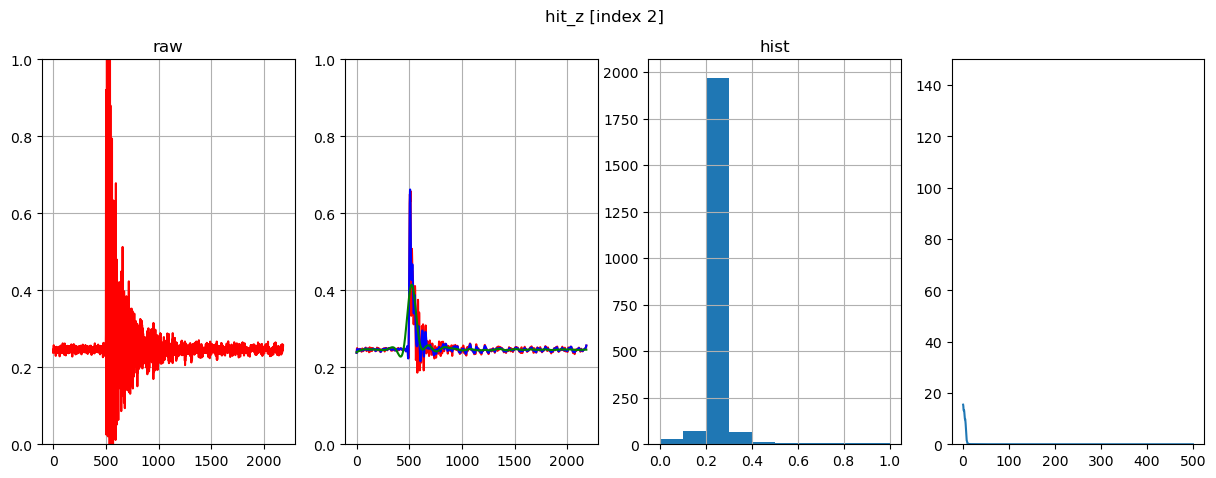

In [101]:
# Визуализация hdf5 объектов
fig, ax = plt.subplots(1,4, figsize = (15, 5))
idx = np.random.choice(label_hdf5.index)

fig.suptitle(label_hdf5[idx] + ' [index {}]'.format(idx))
ax[0].plot(data_hdf5_long[data_hdf5_long['id']== idx]['raw'].reset_index(), color = 'red')
ax[0].set_ylim([0, 1])
ax[0].set_title('raw')
ax[0].grid()

ax[1].plot(data_hdf5_long[data_hdf5_long['id']== idx]['butterworth_100_Hz'].reset_index(drop=True),
           color = 'red', label = 'butterworth_100_Hz')
ax[1].plot(data_hdf5_long[data_hdf5_long['id']== idx]['butterworth_50_Hz'].reset_index(drop=True),
           color = 'blue', label = 'butterworth_50_Hz')
ax[1].plot(data_hdf5_long[data_hdf5_long['id']== idx]['butterworth_7_Hz'].reset_index(drop=True),
           color = 'green', label = 'butterworth_7_Hz')

ax[1].set_ylim([0, 1])
ax[1].grid()

ax[2].hist(data_hdf5_long[data_hdf5_long['id']== idx]['raw'])
ax[2].grid()
ax[2].set_title('hist')

s = data_hdf5_long[data_hdf5_long['id']== idx]['butterworth_7_Hz'].reset_index(drop=True)
sf = np.abs(fft(s))
fs = 1000
N = len(sf)
xf = fftfreq(N, 1/fs)
ax[3].plot(xf[1:N//2], sf[1:N//2])
ax[3].set_ylim([0, 150])

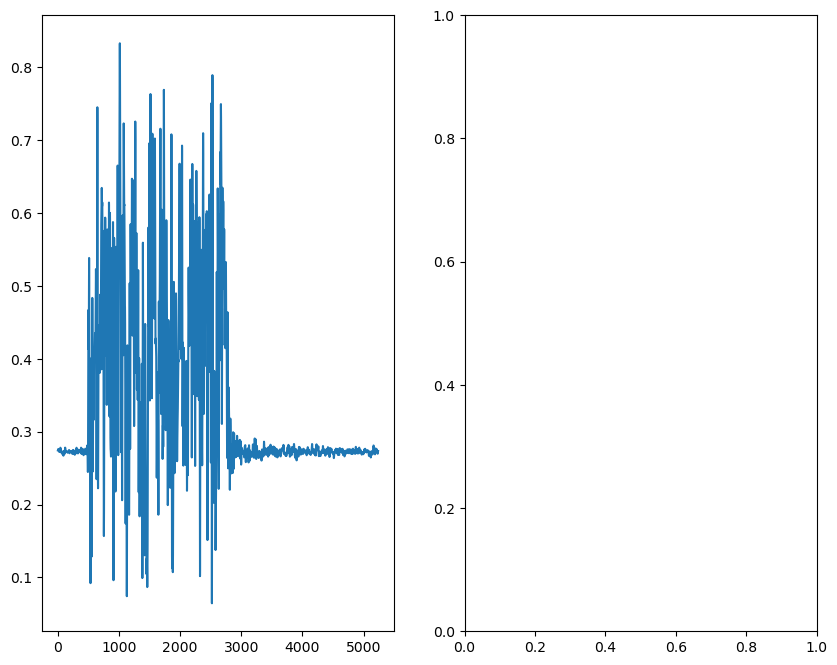

In [41]:

s = data_hdf5_long[data_hdf5_long['id']== idx]['butterworth_75_Hz'].reset_index(drop=True)
fig, ax = plt.subplots(1, 2, figsize = (10,8))
ax[0].plot(s)



In [154]:
# Tsfresh
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from tsfresh.feature_extraction.feature_calculators import set_property

def get_features():
    

    
    sett_answ = {
                "butterworth_50_Hz": {
                                    "skewness": None,
                                    "fft_aggregated": [{"aggtype": "variance"}],
                                    
                        },
                "butterworth_7_Hz": {
                                    "longest_strike_above_mean": None,
                                    "agg_autocorrelation": [{"f_agg": "mean", "maxlag": 500} ],
                                    "agg_linear_trend" : [{"attr": "slope", "chunk_len": 256, "f_agg": "mean" }],
                                    "linear_trend": [{"attr": "stderr"}, {"attr": "intercept"}],
                                    'permutation_entropy': [{'tau': 50, 'dimension': 50},]
                                    
                  
                        },
                "butterword_100_Hz": {"fourier_entropy": None,
                                     "fft_coefficient": [{'coeff': 0, 'attr': 'abs'},
                                                         {'coeff': 1, 'attr': 'abs'},
                                                         {'coeff': 2, 'attr': 'abs'},
                                                         {'coeff': 3, 'attr': 'abs'}],
                                     "partial_autocorrelation": [{"lag": 100}, {"lag": 200}, {"lag": 500}]
                },
                "raw" : {
                        "kurtosis": None,
                        "standard_deviation":None,
                        "length": None,
                        },
                
                }
  
    return sett_answ

In [155]:
import tsfresh
@set_property("fctype", "simple")
def fourier_energy_above_f0(x):
    # Ваше вычисление с параметрами
    result = np.trapz(np.abs(np.fft.fft(x))[1:len(x)//2])
    return result
setattr(tsfresh.feature_extraction.feature_calculators, 'fourier_energy_above_f0', fourier_energy_above_f0)

In [156]:
data_tsfresh = data_hdf5_long
data_tsfresh = extract_features(data_tsfresh, column_id='id',impute_function=impute, column_sort='time',kind_to_fc_parameters = get_features(), n_jobs = 3)

Feature Extraction: 100%|██████████| 15/15 [00:00<00:00, 45.46it/s]


In [130]:
data_tsfresh

,raw__kurtosis,raw__standard_deviation,raw__length,butterworth_7_Hz__longest_strike_above_mean,"butterworth_7_Hz__agg_autocorrelation__f_agg_""mean""__maxlag_500","butterworth_7_Hz__agg_linear_trend__attr_""slope""__chunk_len_256__f_agg_""mean""","butterworth_7_Hz__linear_trend__attr_""stderr""","butterworth_7_Hz__linear_trend__attr_""slope""","butterworth_7_Hz__linear_trend__attr_""intercept""",butterworth_7_Hz__median,butterworth_7_Hz__permutation_entropy__dimension_50__tau_50,butterworth_7_Hz__permutation_entropy__dimension_25__tau_25,butterworth_50_Hz__fourier_energy_above_f0,butterworth_50_Hz__skewness,"butterworth_50_Hz__fft_aggregated__aggtype_""variance"""
0,57.652905,0.067747,2795.0,166.0,0.066089,-0.001334,4.663416e-07,-0.000005,0.260551,0.248809,3.021315,2.089141,558.012033,5.156264,3125.489617
1,46.441004,0.070311,2567.0,169.0,0.075555,-0.001564,5.900781e-07,-0.000007,0.265435,0.251197,2.890269,1.978634,469.966029,6.688469,3136.278598
2,44.903631,0.077993,2183.0,159.0,0.062209,-0.002320,9.560650e-07,-0.000010,0.263570,0.246033,2.687901,1.868598,517.912110,7.008352,5436.079471
3,56.389194,0.070252,2333.0,152.0,0.050707,-0.001124,4.860945e-07,-0.000005,0.253172,0.244042,2.606995,1.807397,354.092697,6.847489,3873.244048
4,95.847140,0.049925,2266.0,143.0,0.058313,-0.000702,2.678718e-07,-0.000003,0.250342,0.245455,2.557869,1.885576,362.309769,8.777827,3689.502855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,8.965978,0.124047,2468.0,566.0,0.304972,-0.005091,1.057535e-06,-0.000020,0.320466,0.277524,3.217749,2.258782,1100.042302,1.751272,4739.335955
418,12.255621,0.090261,2322.0,256.0,0.129554,-0.001392,7.999307e-07,-0.000011,0.292727,0.275157,2.720376,1.933600,903.901761,1.051445,10778.983239
419,31.688639,0.088010,2405.0,265.0,0.095393,-0.002891,1.017846e-06,-0.000013,0.241079,0.215841,2.555301,1.717766,668.254030,4.080657,3723.003595
420,14.881199,0.098094,2007.0,433.0,0.157855,-0.002769,1.029079e-06,-0.000011,0.261815,0.240331,3.175058,2.125465,595.861556,1.547765,5447.180656


In [87]:

data_tsfresh["butterworth_30_Hz__fft_aggregated__aggtype_\"variance\""] =np.log(
    data_tsfresh["butterworth_30_Hz__fft_aggregated__aggtype_\"variance\""])
data_tsfresh["raw__kurtosis"] = np.log(data_tsfresh["raw__kurtosis"])
data_tsfresh["raw__length"] = np.log(data_tsfresh["raw__length"])
data_tsfresh["butterworth_7_Hz__longest_strike_above_mean"] = np.log(data_tsfresh["butterworth_7_Hz__longest_strike_above_mean"])
data_tsfresh["butterworth_30_Hz__fourier_energy_above_f0"] = np.log(data_tsfresh["butterworth_30_Hz__fourier_energy_above_f0"])
data_tsfresh["butterworth_30_Hz__median"] = np.log(data_tsfresh["butterworth_30_Hz__median"])

/home/drozdovmk/anaconda3/envs/ZB/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [144]:
data_tsfresh['label'] = label_hdf5

In [145]:
data_tsfresh

,raw__kurtosis,raw__standard_deviation,raw__length,butterworth_7_Hz__longest_strike_above_mean,"butterworth_7_Hz__agg_autocorrelation__f_agg_""mean""__maxlag_500","butterworth_7_Hz__agg_linear_trend__attr_""slope""__chunk_len_256__f_agg_""mean""","butterworth_7_Hz__linear_trend__attr_""stderr""","butterworth_7_Hz__linear_trend__attr_""intercept""",butterworth_7_Hz__permutation_entropy__dimension_50__tau_50,butterworth_50_Hz__fourier_energy_above_f0,butterworth_50_Hz__skewness,"butterworth_50_Hz__fft_aggregated__aggtype_""variance""",label
0,57.652905,0.067747,2795.0,166.0,0.066089,-0.001334,4.663416e-07,0.260551,3.021315,558.012033,5.156264,3125.489617,hit_z
1,46.441004,0.070311,2567.0,169.0,0.075555,-0.001564,5.900781e-07,0.265435,2.890269,469.966029,6.688469,3136.278598,hit_z
2,44.903631,0.077993,2183.0,159.0,0.062209,-0.002320,9.560650e-07,0.263570,2.687901,517.912110,7.008352,5436.079471,hit_z
3,56.389194,0.070252,2333.0,152.0,0.050707,-0.001124,4.860945e-07,0.253172,2.606995,354.092697,6.847489,3873.244048,hit_z
4,95.847140,0.049925,2266.0,143.0,0.058313,-0.000702,2.678718e-07,0.250342,2.557869,362.309769,8.777827,3689.502855,hit_z
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,8.965978,0.124047,2468.0,566.0,0.304972,-0.005091,1.057535e-06,0.320466,3.217749,1100.042302,1.751272,4739.335955,hit_g
418,12.255621,0.090261,2322.0,256.0,0.129554,-0.001392,7.999307e-07,0.292727,2.720376,903.901761,1.051445,10778.983239,hit_g
419,31.688639,0.088010,2405.0,265.0,0.095393,-0.002891,1.017846e-06,0.241079,2.555301,668.254030,4.080657,3723.003595,hit_g
420,14.881199,0.098094,2007.0,433.0,0.157855,-0.002769,1.029079e-06,0.261815,3.175058,595.861556,1.547765,5447.180656,hit_g


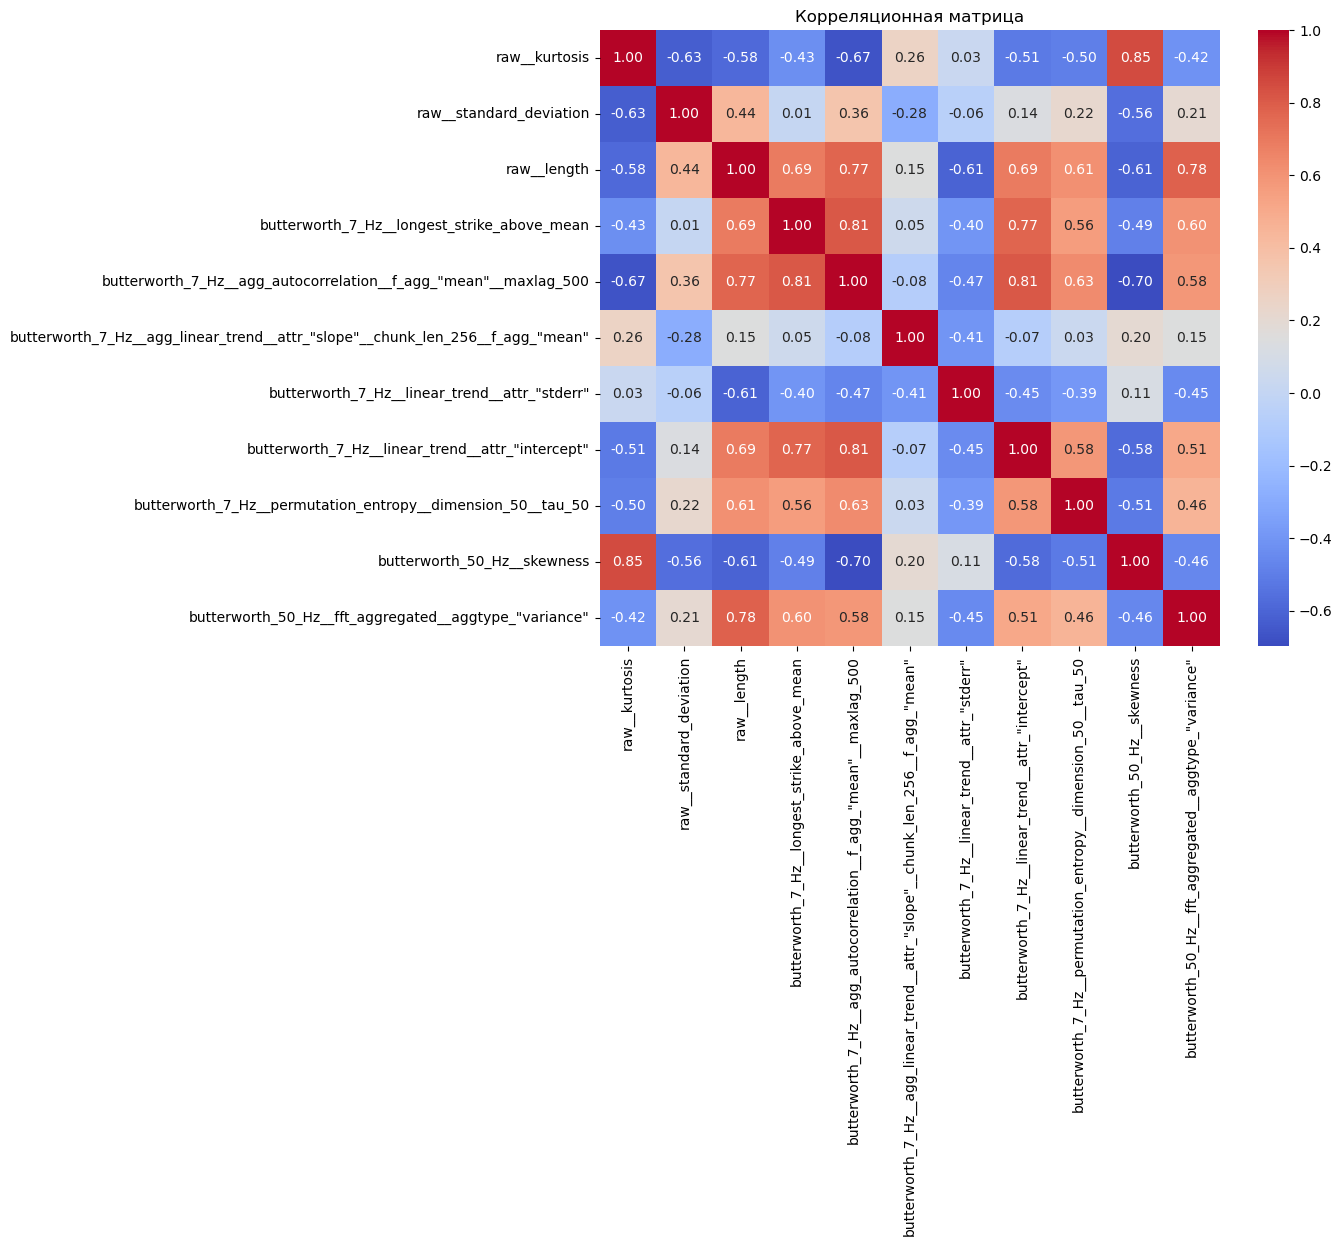

In [157]:
import seaborn as sns
data_tsfresh.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_tsfresh.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

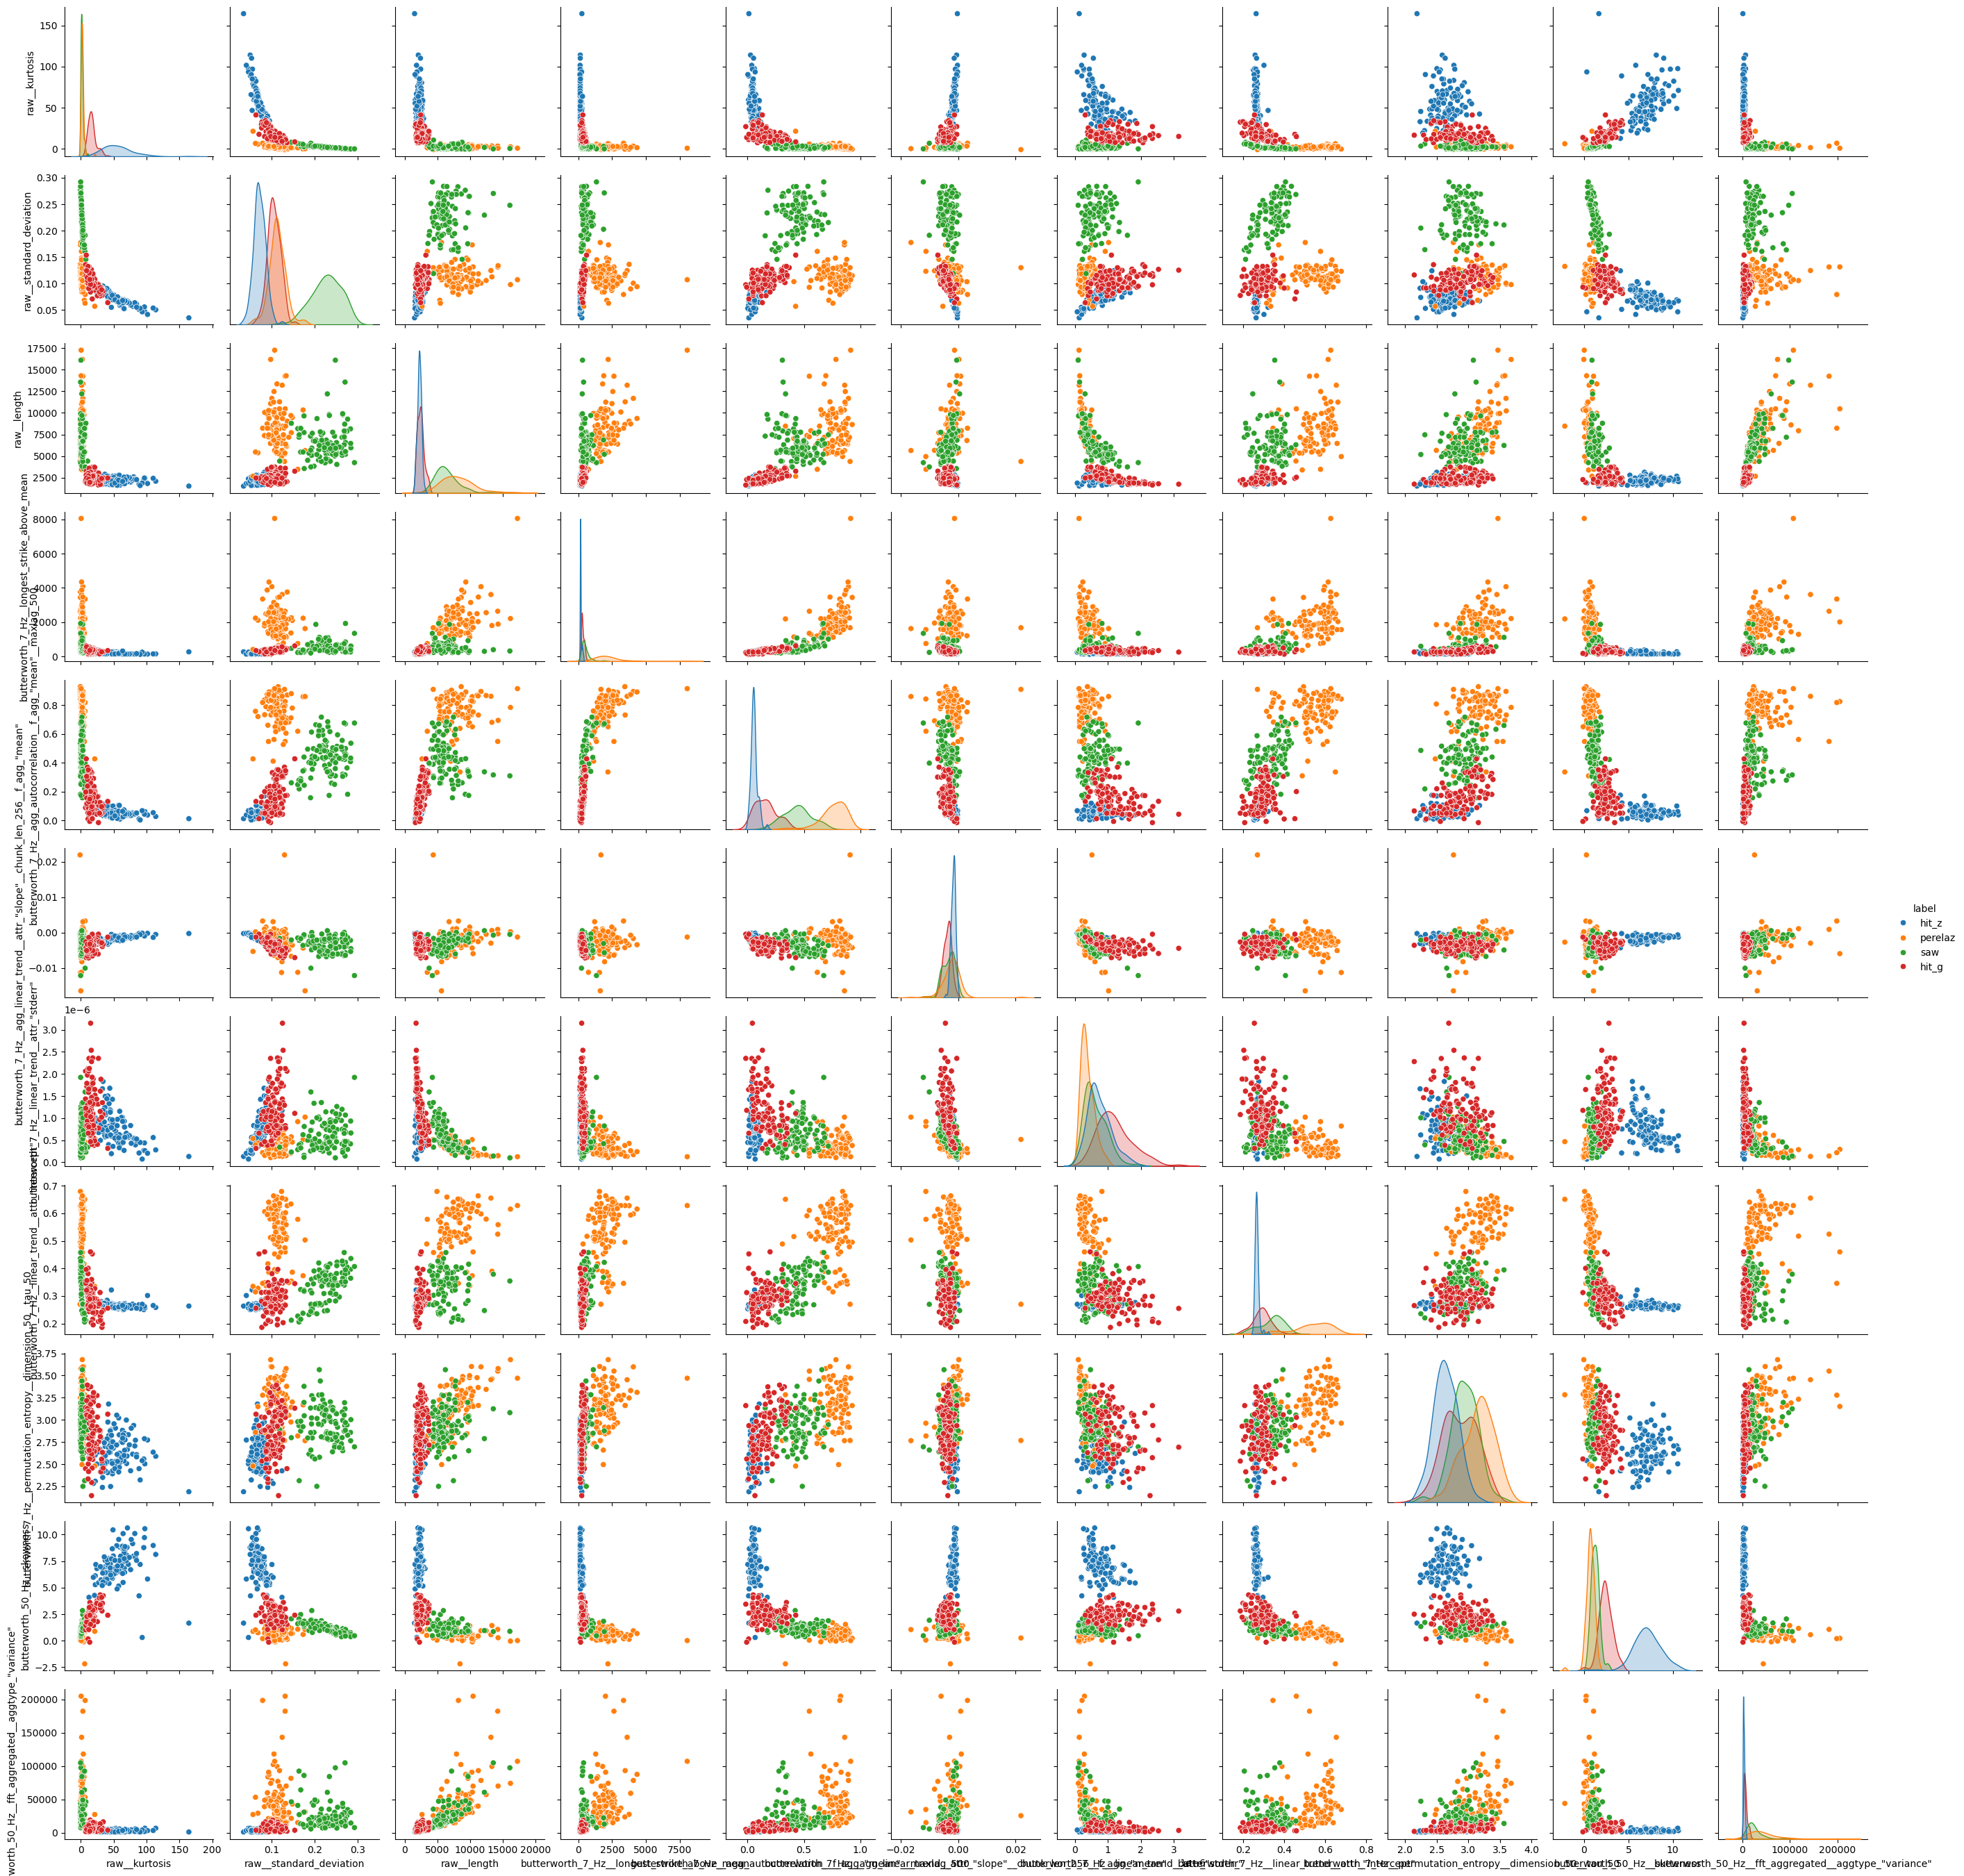

In [159]:
import seaborn as sns
data_tsfresh['label'] = label_hdf5
sns.pairplot(data=data_tsfresh, hue = 'label', )

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

X = data_tsfresh.iloc[:, :-1]
y = data_tsfresh.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True, stratify=y)

In [91]:
param_grid = {
    'classifier__n_estimators': [100, 150, 250, 500],            # Количество деревьев в лесу
    'classifier__criterion': ['gini', 'entropy'],          # Критерий для оценки качества разбиения
    'classifier__max_depth': [None, 10, 20, 30]            # Максимальная глубина дерева
}

rf = Pipeline([('classifier', RandomForestClassifier())])

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_params = grid_search_rf.best_params_
print("Лучшие параметры:", best_params)

# Оцениваем модель на тестовой выборке
best_model_rf = grid_search_rf.best_estimator_
y_pred = best_model_rf.predict(X_test)

# Выводим результаты
print("Отчет по классификации:\n", classification_report(y_test, y_pred))

Лучшие параметры: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__n_estimators': 500}
Отчет по классификации:
               precision    recall  f1-score   support

       hit_g       0.85      1.00      0.92        11
       hit_z       1.00      0.82      0.90        11
     perelaz       1.00      1.00      1.00        10
         saw       1.00      1.00      1.00        11

    accuracy                           0.95        43
   macro avg       0.96      0.95      0.95        43
weighted avg       0.96      0.95      0.95        43



array([0.624, 0.376, 0.   , 0.   ])

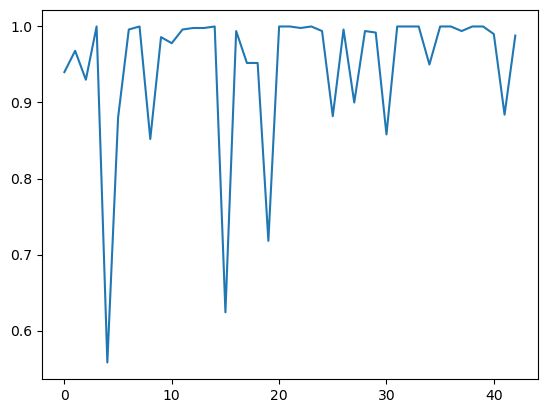

In [92]:
plt.plot(best_model_rf.predict_proba(X_test).max(axis=1))
best_model_rf.predict_proba(X_test)[15]

Text(0.5, 1.0, 'perelaz')

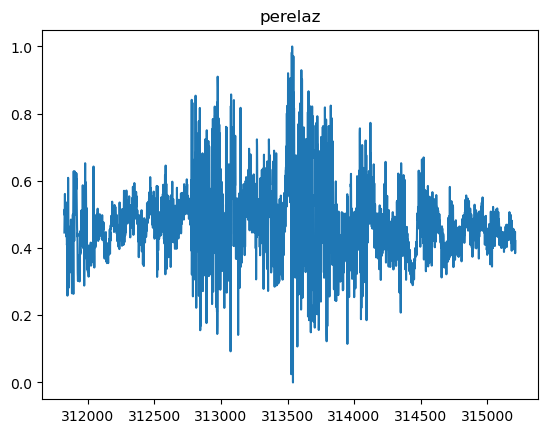

In [54]:
118, 409
plt.plot(data_hdf5_long[data_hdf5_long['id'] == 118]['raw'])
plt.title(label_hdf5[118])